In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=0.2 * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.000e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 34901 
    Total predicted counts          : 34875.28
    Total off counts                : 101385.00

    Total background counts         : 20277.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.72

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 1000
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 3.41 s, sys: 38.7 ms, total: 3.45 s
Wall time: 3.45 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 35056 
    Total predicted counts          : 35011.28
    Total off counts                : 102065.00

    Total background counts         : 20413.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 34660 
    Total predicted counts          : 34896.08
    Total off counts                : 101489.00

    Total background counts         : 2

SpectrumDatasetOnOff

    Name                            : obs_31 

    Total counts                    : 34681 
    Total predicted counts          : 34820.08
    Total off counts                : 101109.00

    Total background counts         : 20221.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_32 

    Total counts                    : 34947 
    Total predicted counts          : 34887.48
    Total off counts                : 101446.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_68 

    Total counts                    : 34979 
    Total predicted counts          : 34814.48
    Total off counts                : 101081.00

    Total background counts         : 20216.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_69 

    Total counts                    : 34707 
    Total predicted counts          : 34806.68
    Total off counts                : 101042.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_90 

    Total counts                    : 34613 
    Total predicted counts          : 34997.88
    Total off counts                : 101998.00

    Total background counts         : 20399.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.14

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_91 

    Total counts                    : 34890 
    Total predicted counts          : 34994.08
    Total off counts                : 101979.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_128 

    Total counts                    : 34783 
    Total predicted counts          : 34881.08
    Total off counts                : 101414.00

    Total background counts         : 20282.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_129 

    Total counts                    : 34953 
    Total predicted counts          : 34784.28
    Total off counts                : 100930.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_166 

    Total counts                    : 35028 
    Total predicted counts          : 34937.28
    Total off counts                : 101695.00

    Total background counts         : 20339.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.82

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_167 

    Total counts                    : 35055 
    Total predicted counts          : 34940.08
    Total off counts                : 101709.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_201 

    Total counts                    : 34958 
    Total predicted counts          : 34803.48
    Total off counts                : 101026.00

    Total background counts         : 20205.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_202 

    Total counts                    : 34803 
    Total predicted counts          : 34925.88
    Total off counts                : 101638.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_235 

    Total counts                    : 34759 
    Total predicted counts          : 34793.68
    Total off counts                : 100977.00

    Total background counts         : 20195.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_236 

    Total counts                    : 34561 
    Total predicted counts          : 34920.68
    Total off counts                : 101612.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_270 

    Total counts                    : 34888 
    Total predicted counts          : 34816.08
    Total off counts                : 101089.00

    Total background counts         : 20217.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_271 

    Total counts                    : 34860 
    Total predicted counts          : 35004.48
    Total off counts                : 102031.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_306 

    Total counts                    : 34941 
    Total predicted counts          : 34834.48
    Total off counts                : 101181.00

    Total background counts         : 20236.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_307 

    Total counts                    : 34871 
    Total predicted counts          : 34930.28
    Total off counts                : 101660.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_342 

    Total counts                    : 34874 
    Total predicted counts          : 34960.88
    Total off counts                : 101813.00

    Total background counts         : 20362.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_343 

    Total counts                    : 35038 
    Total predicted counts          : 34921.48
    Total off counts                : 101616.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_375 

    Total counts                    : 34651 
    Total predicted counts          : 34981.88
    Total off counts                : 101918.00

    Total background counts         : 20383.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_376 

    Total counts                    : 35227 
    Total predicted counts          : 34832.88
    Total off counts                : 101173.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_410 

    Total counts                    : 35042 
    Total predicted counts          : 34839.28
    Total off counts                : 101205.00

    Total background counts         : 20241.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_411 

    Total counts                    : 35183 
    Total predicted counts          : 34941.28
    Total off counts                : 101715.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_446 

    Total counts                    : 35064 
    Total predicted counts          : 34837.08
    Total off counts                : 101194.00

    Total background counts         : 20238.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_447 

    Total counts                    : 35041 
    Total predicted counts          : 34831.28
    Total off counts                : 101165.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_482 

    Total counts                    : 34575 
    Total predicted counts          : 34843.08
    Total off counts                : 101224.00

    Total background counts         : 20244.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_483 

    Total counts                    : 34648 
    Total predicted counts          : 34802.88
    Total off counts                : 101023.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_520 

    Total counts                    : 34600 
    Total predicted counts          : 34842.28
    Total off counts                : 101220.00

    Total background counts         : 20244.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_521 

    Total counts                    : 34858 
    Total predicted counts          : 34958.28
    Total off counts                : 101800.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_554 

    Total counts                    : 34892 
    Total predicted counts          : 34952.88
    Total off counts                : 101773.00

    Total background counts         : 20354.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.67

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_555 

    Total counts                    : 35290 
    Total predicted counts          : 34779.48
    Total off counts                : 100906.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_589 

    Total counts                    : 34886 
    Total predicted counts          : 34950.28
    Total off counts                : 101760.00

    Total background counts         : 20352.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_590 

    Total counts                    : 35380 
    Total predicted counts          : 35003.88
    Total off counts                : 102028.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_622 

    Total counts                    : 34729 
    Total predicted counts          : 34835.08
    Total off counts                : 101184.00

    Total background counts         : 20236.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_623 

    Total counts                    : 35083 
    Total predicted counts          : 34863.68
    Total off counts                : 101327.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_657 

    Total counts                    : 34459 
    Total predicted counts          : 34854.28
    Total off counts                : 101280.00

    Total background counts         : 20256.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_658 

    Total counts                    : 34706 
    Total predicted counts          : 34962.48
    Total off counts                : 101821.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_692 

    Total counts                    : 34988 
    Total predicted counts          : 35007.08
    Total off counts                : 102044.00

    Total background counts         : 20408.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_693 

    Total counts                    : 34998 
    Total predicted counts          : 34918.88
    Total off counts                : 101603.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_728 

    Total counts                    : 34696 
    Total predicted counts          : 34921.28
    Total off counts                : 101615.00

    Total background counts         : 20323.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_729 

    Total counts                    : 35045 
    Total predicted counts          : 34817.08
    Total off counts                : 101094.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_765 

    Total counts                    : 34831 
    Total predicted counts          : 34982.28
    Total off counts                : 101920.00

    Total background counts         : 20384.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_766 

    Total counts                    : 34741 
    Total predicted counts          : 34882.28
    Total off counts                : 101420.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_798 

    Total counts                    : 34682 
    Total predicted counts          : 34869.08
    Total off counts                : 101354.00

    Total background counts         : 20270.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_799 

    Total counts                    : 35045 
    Total predicted counts          : 34743.08
    Total off counts                : 100724.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_833 

    Total counts                    : 34881 
    Total predicted counts          : 34914.28
    Total off counts                : 101580.00

    Total background counts         : 20316.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 19.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_834 

    Total counts                    : 34678 
    Total predicted counts          : 34850.88
    Total off counts                : 101263.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_867 

    Total counts                    : 34541 
    Total predicted counts          : 34825.88
    Total off counts                : 101138.00

    Total background counts         : 20227.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_868 

    Total counts                    : 34803 
    Total predicted counts          : 34906.48
    Total off counts                : 101541.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_904 

    Total counts                    : 34762 
    Total predicted counts          : 34905.88
    Total off counts                : 101538.00

    Total background counts         : 20307.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_905 

    Total counts                    : 35086 
    Total predicted counts          : 34932.08
    Total off counts                : 101669.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_938 

    Total counts                    : 34882 
    Total predicted counts          : 34878.88
    Total off counts                : 101403.00

    Total background counts         : 20280.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_939 

    Total counts                    : 35263 
    Total predicted counts          : 34907.68
    Total off counts                : 101547.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_976 

    Total counts                    : 35315 
    Total predicted counts          : 34856.68
    Total off counts                : 101292.00

    Total background counts         : 20258.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_977 

    Total counts                    : 34606 
    Total predicted counts          : 34978.88
    Total off counts                : 101903.00

    Total background counts        

Text(0, 0.5, 'No. of observations')

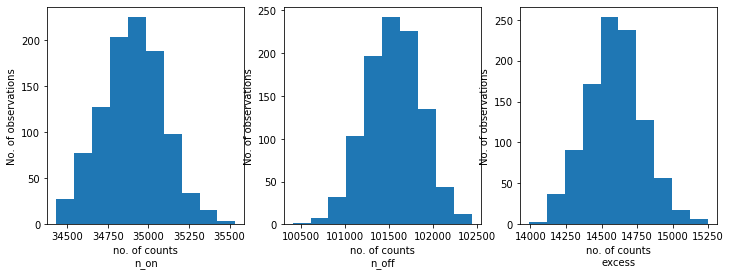

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "lambda_": result.parameters["lambda_"].value,
        }
    )

CPU times: user 4min 23s, sys: 471 ms, total: 4min 23s
Wall time: 4min 59s


In [15]:
results

[{'index': 2.2065245213780615,
  'amplitude': 1.314624792989545e-12,
  'lambda_': 0.19822373303885332},
 {'index': 2.2241296518600198,
  'amplitude': 1.2597427958332657e-12,
  'lambda_': 0.19849869006038268},
 {'index': 2.2215816290774106,
  'amplitude': 1.2599389030670734e-12,
  'lambda_': 0.20433315945555797},
 {'index': 2.2255111002319556,
  'amplitude': 1.2639165786699223e-12,
  'lambda_': 0.20108668021471066},
 {'index': 2.2405402452329235,
  'amplitude': 1.2800212266093838e-12,
  'lambda_': 0.1987347318716423},
 {'index': 2.196569540293972,
  'amplitude': 1.3394190116344316e-12,
  'lambda_': 0.22642936450661244},
 {'index': 2.25270088300736,
  'amplitude': 1.218659850841904e-12,
  'lambda_': 0.1711351607368041},
 {'index': 2.2179245864540587,
  'amplitude': 1.3006138000014736e-12,
  'lambda_': 0.20956042677926046},
 {'index': 2.2087873646636726,
  'amplitude': 1.2841801081009587e-12,
  'lambda_': 0.19274956641335284},
 {'index': 2.249279839203157,
  'amplitude': 1.216292553466284

index: 2.21959851751929 += 0.015670888404581647


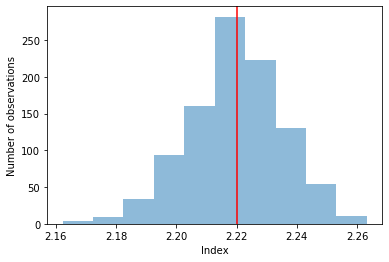

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.2903492411315216e-12 += 3.8636668344198056e-14


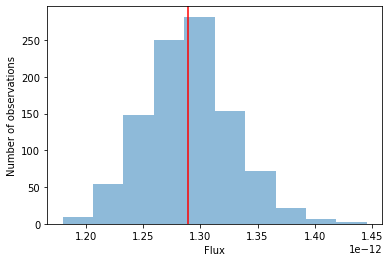

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

lambda_: 0.2008948816793453 += 0.01565158554889314


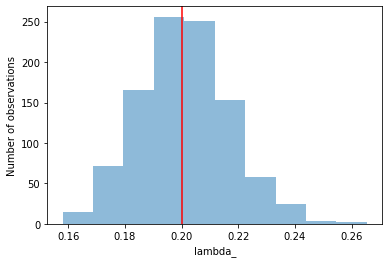

In [18]:
lambda_ = np.array([_["lambda_"] for _ in results])
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
plt.xlabel("lambda_")
plt.ylabel("Number of observations")
print(f"lambda_: {lambda_.mean()} += {lambda_.std()}")